# Set up

In [247]:
import pandas as pd
import pandas_profiling
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [248]:
%matplotlib inline

In [266]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)

# Getting data

In [250]:
# qubit-datateam.footbot.element_gameweek_features_v06
file_name = '../csvs/element_gameweek_features_v06.csv'

In [251]:
element_gameweek_df = pd.read_csv(file_name)

In [252]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,is_sunday,is_weekday,is_early,...,rolling_avg_goals_conceded_opposition_team,rolling_avg_total_points_element_type,rolling_avg_total_points_against_opposition_team,rolling_avg_total_points_against_opposition_team_element_type,expected_total_points_against_opposition_team,rolling_avg_total_points_against_opposition_team_element_type_home,rolling_avg_total_points_against_opposition_team_element_type_away,expected_total_points_against_opposition_team_home_away,total_points,minutes
0,cech,1,1,1,1,13,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,90
1,cech,1,2,14,1,6,0,0,0,0,...,0.000000,4.400000,1.153846,1.0,0.681818,1.000000,NaN,NaN,3,90
2,cech,1,3,21,1,19,1,0,0,0,...,3.000000,4.000000,4.666667,5.0,3.750000,7.000000,3.0,5.250000,3,90
3,cech,1,4,33,1,5,0,1,0,1,...,0.666667,3.672131,3.785714,5.5,4.493304,5.333333,6.0,4.901786,1,90
4,cech,1,5,46,1,15,0,0,0,0,...,1.500000,3.753086,3.446429,5.5,3.663651,9.000000,2.0,1.332237,2,90


In [253]:
list(element_gameweek_df.columns)

['safe_web_name',
 'element',
 'event',
 'fixture',
 'team',
 'opposition_team',
 'was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'element_type',
 'value',
 'rolling_value_points',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling

# Analysis

In [254]:
# entire dataset
len(element_gameweek_df)

21790

In [255]:
# dataset of players with minutes
len(element_gameweek_df[element_gameweek_df['minutes'] > 0])

10480

In [256]:
# players
len(element_gameweek_df['element'].drop_duplicates())

624

In [257]:
# players by position
element_gameweek_df[['element', 'element_type']].drop_duplicates().groupby('element_type').size()

element_type
1     64
2    217
3    252
4     91
dtype: int64

In [258]:
# player participation
element_gameweek_df.groupby('element')['minutes'].mean().describe(
    [
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.65,
        0.7,
        0.8,
        0.9
    ]
)

count    624.000000
mean      32.504234
std       29.384265
min        0.000000
10%        0.000000
20%        0.075598
30%        5.622727
40%       15.563158
50%       26.184211
60%       40.252632
65%       46.496053
70%       52.447368
80%       63.310526
90%       77.874436
max       90.000000
Name: minutes, dtype: float64

In [259]:
# training set
element_gameweek_df = element_gameweek_df[element_gameweek_df['event'] <= 20]
len(element_gameweek_df)

10961

## Target-feature correlation

In [267]:
element_gameweek_df.corrwith(element_gameweek_df['total_points']).sort_values(ascending=False)

total_points                                                          1.000000
minutes                                                               0.613279
rolling_avg_minutes_element_p3                                        0.451474
rolling_avg_total_points_element                                      0.443097
rolling_avg_minutes_element                                           0.440444
rolling_avg_bps_element                                               0.430300
expected_total_points_against_opposition_team_home_away               0.428337
expected_total_points_against_opposition_team                         0.427135
rolling_avg_total_points_element_p3                                   0.427014
rolling_avg_total_points_element_home                                 0.420389
rolling_max_total_points_element                                      0.404314
rolling_value_points                                                  0.401987
rolling_avg_total_points_element_away               

In [268]:
frequent_element_gameweek_df = element_gameweek_df.copy()
frequent_element_gameweek_df = frequent_element_gameweek_df[frequent_element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]
len(frequent_element_gameweek_df)

3644

In [269]:
abs(frequent_element_gameweek_df.corrwith(frequent_element_gameweek_df['total_points'])).sort_values(ascending=False)

total_points                                                          1.000000
minutes                                                               0.372178
value                                                                 0.246020
expected_total_points_against_opposition_team_home_away               0.217429
expected_total_points_against_opposition_team                         0.211246
rolling_avg_total_points_element_home                                 0.206403
rolling_avg_total_points_element                                      0.197933
rolling_avg_total_points_element_p3                                   0.171123
rolling_max_total_points_element                                      0.162579
rolling_avg_big_chances_missed_element                                0.158210
rolling_avg_goals_scored_element                                      0.154248
rolling_avg_bps_element                                               0.150624
rolling_avg_key_passes_element                      

## Target distribution

In [270]:
frequent_element_gameweek_df['total_points'].describe()

count    3644.000000
mean        2.869374
std         3.093733
min        -4.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        21.000000
Name: total_points, dtype: float64

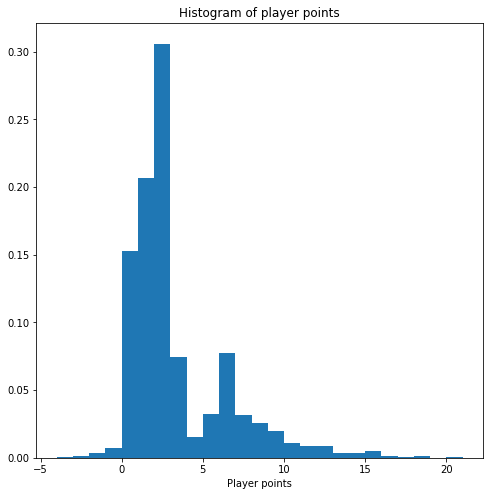

In [377]:
plt.figure(figsize=(8,8))
plt.title('Histogram of player points')
plt.xlabel('Player points')
plt.hist(frequent_element_gameweek_df['total_points'], bins=25, density=True)
plt.show()

In [395]:
analysis_df = frequent_element_gameweek_df.copy()

analysis_df['is_high_points'] = \
analysis_df['total_points'].apply(lambda x: 1 if x >= 5 else 0)

analysis_df['is_very_high_points'] = \
analysis_df['total_points'].apply(lambda x: 1 if x >= 10 else 0)

In [396]:
abs(analysis_df.corrwith(analysis_df['is_high_points'])).sort_values(ascending=False)

is_high_points                                                        1.000000
total_points                                                          0.856042
is_very_high_points                                                   0.391300
minutes                                                               0.243226
expected_total_points_against_opposition_team_home_away               0.199775
value                                                                 0.185590
expected_total_points_against_opposition_team                         0.172242
rolling_avg_total_points_element_home                                 0.167661
rolling_avg_total_points_element                                      0.162389
rolling_avg_bps_element                                               0.150874
rolling_max_total_points_element                                      0.134049
rolling_avg_total_points_element_p3                                   0.128122
rolling_avg_goals_conceded_opposition_team          

In [397]:
abs(analysis_df.corrwith(analysis_df['is_very_high_points'])).sort_values(ascending=False)

is_very_high_points                                                   1.000000
total_points                                                          0.658363
is_high_points                                                        0.391300
value                                                                 0.179999
rolling_avg_key_passes_element                                        0.126967
rolling_avg_total_points_element_home                                 0.117593
rolling_avg_big_chances_missed_element                                0.115575
expected_total_points_against_opposition_team                         0.115178
rolling_avg_total_points_element                                      0.112481
rolling_max_total_points_element                                      0.112212
rolling_avg_goals_scored_element                                      0.111654
has_high_points_ever_element                                          0.107818
expected_total_points_against_opposition_team_home_a

In [393]:
frequent_element_gameweek_df['expected_total_points_against_opposition_team_home_away'].describe(
[
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.65,
        0.7,
        0.8,
        0.9
    ])

count    3435.000000
mean        2.996609
std         2.200944
min        -2.808421
10%         0.897060
20%         1.357435
30%         1.750588
40%         2.137519
50%         2.539797
60%         2.975310
65%         3.215628
70%         3.551172
80%         4.286470
90%         5.495855
max        22.768895
Name: expected_total_points_against_opposition_team_home_away, dtype: float64

In [272]:
frequent_element_gameweek_df.groupby('element')['total_points'].max().describe([0.75, 0.8, 0.85, 0.9, 0.95])

count    355.000000
mean       7.073239
std        4.626775
min        0.000000
50%        7.000000
75%       10.000000
80%       11.000000
85%       12.000000
90%       14.000000
95%       15.000000
max       21.000000
Name: total_points, dtype: float64

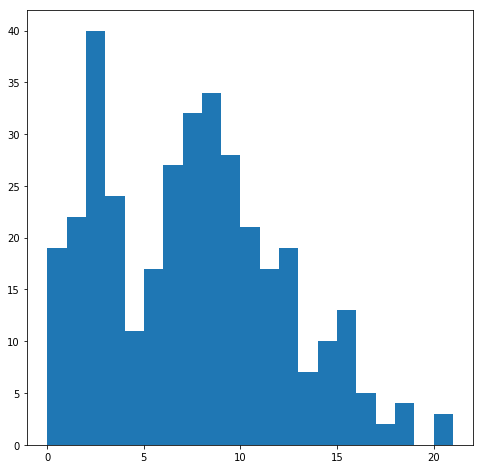

In [273]:
plt.figure(figsize=(8,8))
plt.hist(frequent_element_gameweek_df.groupby('element')['total_points'].max(), bins=21)
plt.show()

## Pairwise correlations

In [369]:
cols = [
'value',
'expected_total_points_against_opposition_team_home_away',
#'expected_total_points_against_opposition_team', # have home away
#'rolling_avg_total_points_element_home', # have home away
'rolling_avg_total_points_element',
'rolling_avg_total_points_element_p3',
#'rolling_max_total_points_element', # have dummy
'rolling_avg_big_chances_missed_element',
'rolling_avg_goals_scored_element',
#'rolling_avg_bps_element', # highlly explained
'rolling_avg_key_passes_element',
#'expected_total_points_element_home_away', # expected against accounts for home away
#'rolling_avg_total_points_element_away', # expected against accounts for home away
#'rolling_avg_total_points_own_team', # high explained
'rolling_avg_target_missed_element',
'rolling_avg_bonus_element',
'has_high_points_ever_element',
'rolling_avg_tackled_element',
#'rolling_avg_total_points_against_opposition_team', # have expected against
#'rolling_avg_minutes_element', # highly explained
'rolling_avg_goals_scored_opposition_team',
#'rolling_avg_total_points_opposition_team', # have goals scored and conceded
#'rolling_avg_dribbles_element', # highly correlated with tackled
'rolling_avg_goals_conceded_opposition_team',
'rolling_avg_big_chances_created_element',
#'rolling_avg_total_points_against_opposition_team_element_type', # have expected against
#'rolling_avg_total_points_against_opposition_team_element_type_away', # have expected against
'rolling_avg_assists_element',
'rolling_avg_clean_sheets_element',
'rolling_avg_offside_element',
'rolling_avg_winning_goals_element',
'rolling_avg_clearances_blocks_interceptions_element',
#'rolling_avg_total_points_against_opposition_team_element_type_home', # have home away
'rolling_avg_minutes_element_p3',
'rolling_avg_penalties_missed_element',
'rolling_avg_yellow_cards_element',
'rolling_avg_saves_element',
'rolling_avg_attempted_passes_element',
#'rolling_avg_goals_conceded_element', # have team goals conceded
'rolling_avg_penalties_saved_element',
#'rolling_avg_completed_passes_element', # have attempted passes
'is_late',
'is_weekday',
'rolling_avg_open_play_crosses_element',
'was_home',
'rolling_avg_tackles_element',
'rolling_avg_errors_leading_to_goal_element',
#'rolling_avg_total_points_element_type', # have expected
#'rolling_avg_recoveries_element', # highly explained
'rolling_avg_red_cards_element',
'rolling_avg_penalties_concededd_element',
'rolling_avg_errors_leading_to_goal_attempt_element',
'is_sunday',
'rolling_avg_fouls_element',
'rolling_avg_own_goals_element',
'is_early',
]

feature_df = frequent_element_gameweek_df[cols].copy().dropna()

In [370]:
corr = feature_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### Variance inflation factors

In [353]:
vif = pd.DataFrame()
vif['vif'] = \
[
    variance_inflation_factor(feature_df.values, i)
    for i in range(0, len(cols))]
vif['features'] = cols

In [354]:
vif[vif['vif'] > 10]

,vif,features
0,31.168483,value
2,76.937411,rolling_avg_total_points_element
19,42.950314,rolling_avg_minutes_element_p3
23,10.655435,rolling_avg_attempted_passes_element


### Principal component analysis

In [355]:
scaler = StandardScaler().fit(feature_df.values)
scaled_df = scaler.transform(feature_df.values)

In [356]:
pca = PCA(n_components=None, whiten=False)

In [357]:
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [358]:
pca.explained_variance_ratio_.round(2)

array([0.19, 0.07, 0.07, 0.05, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  ])

In [359]:
sum(pca.explained_variance_ratio_[:36])

0.9948898486291555

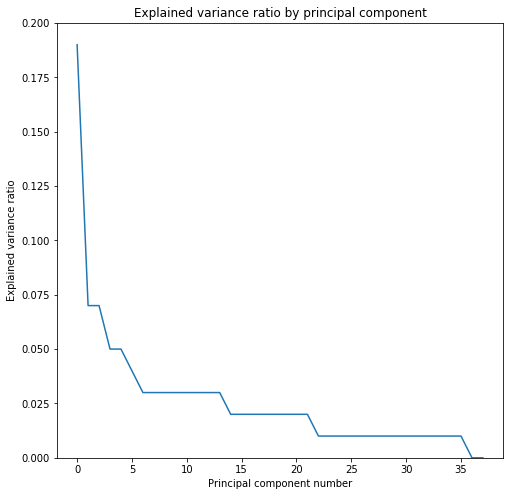

In [373]:
plt.figure(figsize=(8, 8))
plt.title('Explained variance ratio by principal component')
plt.xlabel('Principal component number')
plt.ylabel('Explained variance ratio')
plt.plot(pca.explained_variance_ratio_.round(2))
plt.ylim(0, 0.2)
plt.show()

In [361]:
components_df = pd.DataFrame(pca.components_).iloc[:36]
components_df.columns = cols

In [362]:
components_df.head(10)

,value,expected_total_points_against_opposition_team_home_away,rolling_avg_total_points_element,rolling_avg_total_points_element_p3,rolling_avg_big_chances_missed_element,rolling_avg_goals_scored_element,rolling_avg_key_passes_element,rolling_avg_target_missed_element,rolling_avg_bonus_element,has_high_points_ever_element,...,was_home,rolling_avg_tackles_element,rolling_avg_errors_leading_to_goal_element,rolling_avg_red_cards_element,rolling_avg_penalties_concededd_element,rolling_avg_errors_leading_to_goal_attempt_element,is_sunday,rolling_avg_fouls_element,rolling_avg_own_goals_element,is_early
0,0.290693,0.229655,0.304664,0.241986,0.217018,0.301413,0.265166,0.223753,0.255115,0.214893,...,0.000407,0.019045,-0.056942,-0.006418,-0.021727,-0.072054,0.025758,0.095940,-0.028092,0.025494
1,0.029565,0.215322,0.217626,0.216367,-0.034797,0.011131,-0.160029,-0.160487,0.156728,0.104026,...,0.010273,-0.283202,0.098667,-0.033389,-0.049120,0.124799,0.015054,-0.385286,-0.056063,0.017934
2,-0.156020,0.185446,0.215189,0.113082,-0.220630,-0.090363,-0.007528,-0.092868,0.205534,0.008496,...,0.005578,0.315836,0.041177,0.007908,0.128301,0.089385,0.062053,0.108051,0.043651,0.067336
3,-0.029648,0.257572,-0.040704,-0.038751,-0.014179,-0.007757,0.010217,0.026428,-0.009748,-0.006118,...,0.001083,0.056596,-0.000192,0.007667,0.036554,-0.015057,-0.333526,0.033838,0.011330,-0.313687
4,0.068360,0.018399,0.054435,0.035887,0.244956,0.221840,-0.353702,0.171619,0.011226,0.004759,...,-0.004506,0.005988,-0.010393,0.071821,0.252419,0.023524,-0.049904,0.215373,-0.018901,-0.077265
5,-0.021912,-0.066014,0.030678,0.066122,-0.078941,-0.018975,0.033542,-0.056792,0.066030,0.061198,...,-0.004556,0.010561,0.013904,-0.008910,0.002505,0.003691,-0.256727,-0.020453,-0.012494,-0.467119
6,0.077638,0.095947,0.004631,-0.045533,0.192975,-0.168163,0.042655,0.132859,-0.256965,-0.286755,...,-0.006594,-0.014686,-0.133898,-0.189347,-0.275300,0.244151,0.201317,0.041180,-0.068839,-0.006012
7,-0.147231,-0.042575,0.003543,-0.013124,0.195762,-0.030061,0.004102,0.054793,-0.029983,0.020676,...,0.024303,-0.037378,0.158615,-0.221614,0.016972,0.283195,-0.335782,0.092876,0.315354,-0.132766
8,-0.016743,0.007160,0.008630,-0.033408,-0.180710,0.028957,0.018518,-0.007473,-0.083476,0.114565,...,-0.095835,-0.053181,-0.089851,-0.278628,-0.054958,-0.078329,0.069586,0.298116,-0.253661,-0.011069
9,-0.046124,-0.021239,0.046772,0.059208,-0.011469,-0.035280,0.007673,-0.012627,0.015072,-0.098488,...,-0.056649,0.212881,-0.129656,0.511887,-0.181081,-0.172051,-0.385663,0.018680,-0.321093,-0.166047


In [363]:
transformed_features_df = pd.DataFrame(pca.transform(scaled_df)).iloc[:,:36]

In [364]:
transformed_corr = transformed_features_df.corr()
transformed_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,1,-6.7e-15,2.9e-15,1.7e-16,-1.5e-15,2.8e-16,-6.3e-16,-5.9e-16,1.4e-15,6.6e-16,-4.1e-16,-5.7e-17,-6.2e-16,1.7e-16,-4.5e-16,-6.8e-16,-2e-17,5.6e-17,6.1e-17,1.3e-16,-1e-15,1.8e-15,-2.3e-15,-1.6e-17,3.9e-16,9.5e-16,3.1e-16,2.7e-15,3.2e-17,1.2e-15,8.8e-17,1.5e-15,7.6e-16,-1.2e-15,2.5e-15,-1e-15
1,-6.7e-15,1,4.7e-16,-5.9e-16,4.4e-16,-6.9e-17,4.7e-17,1.9e-16,2.3e-17,-6.6e-17,2.7e-16,2.2e-18,3.5e-16,9.2e-17,5.7e-18,-6.5e-17,-6.3e-17,-4e-16,-1.5e-16,9.3e-17,1.4e-16,-3.6e-17,1.5e-17,2.4e-16,-4.9e-16,-5.5e-16,4.6e-16,-3e-16,-1e-16,-3.9e-16,4.2e-16,5.1e-16,-3.3e-16,7.5e-17,1.9e-16,4.6e-16
2,2.9e-15,4.7e-16,1,-1e-16,6.9e-16,4.1e-17,3.8e-16,-6.7e-17,-6.2e-16,-2.8e-16,-2.2e-16,9.3e-17,2.2e-16,2.8e-17,2.5e-16,-2.4e-16,-1.4e-16,-1.9e-16,4.9e-16,-2.7e-16,-5e-16,-1e-15,1e-15,6.8e-17,-4.5e-16,-2.7e-16,-4.7e-16,-1.5e-15,-2e-16,-5.5e-16,5.9e-16,-1.4e-16,1.6e-16,6.3e-16,-1.1e-15,-1.4e-15
3,1.7e-16,-5.9e-16,-1e-16,1,4.5e-16,-1e-16,8.7e-16,-6.4e-16,-2.4e-16,-2.2e-16,-1.5e-16,1.5e-16,-1.2e-16,-1.2e-16,1.9e-16,1.4e-16,2.8e-16,7.5e-17,3.6e-16,1.3e-16,-2.5e-16,-1e-16,1.5e-16,-4.4e-17,1.1e-16,1.6e-16,1.9e-16,2.7e-16,-1.2e-16,1.2e-16,1.6e-16,-5e-16,-1.5e-16,9.2e-16,-9.2e-16,-3.4e-16
4,-1.5e-15,4.4e-16,6.9e-16,4.5e-16,1,-2.7e-17,5.4e-16,-1e-15,4.2e-17,1.1e-16,-1.5e-16,-1.9e-16,-6.1e-17,4.6e-17,6.3e-17,-1.2e-17,2.5e-17,-1.6e-16,-2.4e-16,-2.3e-16,7.1e-16,3.7e-16,1.1e-17,5.5e-17,4.2e-16,6.3e-17,1.5e-16,5.3e-16,-3.8e-16,1.7e-16,-5.3e-16,6.8e-17,-2.2e-16,4.1e-17,5.8e-16,1e-15
5,2.8e-16,-6.9e-17,4.1e-17,-1e-16,-2.7e-17,1,-7.8e-16,-4.3e-18,1.1e-16,-2.1e-16,-9.4e-18,9.8e-17,-1.6e-16,-2e-16,-3.2e-16,-7.7e-18,2.4e-16,3.2e-16,4.8e-16,-3e-16,-7.3e-16,-2.3e-16,4e-17,2.1e-19,-2.1e-16,1.2e-16,9.8e-17,1.7e-16,-3e-16,-3.6e-17,-5.9e-17,-8.2e-17,3.6e-16,-4.5e-16,3.4e-17,2.7e-16
6,-6.3e-16,4.7e-17,3.8e-16,8.7e-16,5.4e-16,-7.8e-16,1,-7.4e-16,1.7e-16,-4.6e-16,-2e-16,2.3e-17,-1.4e-16,-6e-17,-3.2e-16,-2.1e-16,9.2e-18,2.6e-16,-3.5e-17,-6e-17,-3.5e-16,5.3e-16,-4.8e-16,-2.8e-16,-1.2e-16,2e-16,3.4e-17,5e-16,-2.3e-16,1.6e-16,-2.9e-16,-3.9e-16,-4.8e-16,-1.6e-16,1.8e-16,-7.7e-16
7,-5.9e-16,1.9e-16,-6.7e-17,-6.4e-16,-1e-15,-4.3e-18,-7.4e-16,1,-3.8e-16,-2.9e-16,-5.4e-16,3.1e-16,-3.8e-16,-3.8e-16,-2.3e-17,2.1e-16,-3.4e-16,-2.2e-16,-4e-16,-5.9e-18,2.8e-16,-2.4e-17,4.7e-16,-2.3e-16,-1.8e-16,-6.1e-16,1.5e-16,-2.9e-16,6e-17,-1.8e-16,1e-16,-7.7e-16,-8.3e-16,8.4e-16,-2e-16,3.3e-16
8,1.4e-15,2.3e-17,-6.2e-16,-2.4e-16,4.2e-17,1.1e-16,1.7e-16,-3.8e-16,1,1.5e-16,2e-16,9.1e-17,-9e-16,-4.2e-16,3.5e-16,-3.7e-16,3.4e-16,-3e-16,2.1e-16,-3.5e-16,2.9e-17,-1.2e-15,6.9e-18,2.9e-16,4.6e-16,-3e-17,-3.2e-16,-6.9e-16,1.6e-16,9.1e-17,-1.7e-16,-2.7e-16,6.9e-16,-2.8e-17,-8e-17,-1.2e-16
9,6.6e-16,-6.6e-17,-2.8e-16,-2.2e-16,1.1e-16,-2.1e-16,-4.6e-16,-2.9e-16,1.5e-16,1,9.7e-16,2.6e-16,-3.8e-16,-8.3e-16,-1.3e-16,-2.7e-16,-8.1e-16,4.3e-17,3e-16,-2.8e-16,1.6e-16,-4e-16,2e-16,1.8e-17,-1.8e-16,-2.9e-16,-9e-17,-6e-16,-3.3e-17,-1.6e-16,2.2e-16,-2.1e-16,-4.4e-17,4.1e-16,3.3e-16,1.7e-16


In [365]:
transformed_vif = pd.DataFrame()
transformed_vif['vif'] = \
[
    variance_inflation_factor(transformed_features_df.values, i)
    for i in range(0, len(transformed_features_df.columns))]

In [366]:
transformed_vif['vif'].round(3).describe()

count    36.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: vif, dtype: float64